# Landscape Ground State Landscape Neural Net
## 1. Goal
The goal of this project is to show case the effectiveness of the landscape function by comparing a simple machine learning architecture (CNN + dense) when trained on
1. potential $V$ only, or
2. landscape $u$ only, or
3. both $u$ and $V$.
to predict the lower ground state energy of a Schrodinger's operator. 

More precisely,
- Given a potential $V$ on $L^2(Q_L)$ where $Q_L = [0, L] \cap \mathbb{Z}$ with periodic boundary condition
- Find the ground state eigenvalue of the disrete Schrodinger Hamiltonian $-\Delta+V$ where $-\Delta$ is the discrite Laplacian on $\mathbb{Z}$.

### Architecture
- CNN + fully connected NN
- implemented by hand as python classes (not using tf.keras.Sequential), to facilitate future upgrades
- No optimization such as image augmentation/rotation/translation


## 2. Setting constants

In [1]:
BOXLENGTH = 1000
KERNEL_SIZE = 10
STRIDES = 10
DATA_SIZE = 1000
BATCH_SIZE = 32
EPOCHS = 30
V_GEN = lambda x, y : 4.0*np.random.rand(x,y) # random potential: x = batch size, y = boxlength

## 3. Import neccessary libraries

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np

# tensorflow
import tensorflow as tf
from tensorflow.keras import layers, Model

# eigenvalue solver
from petsc4py import PETSc
from slepc4py import SLEPc

# Plot
from matplotlib import pylab

## 4. Obtaining training/testing data

## Getting the eigenvalues and the landscape function

In [3]:
class GS_data_generator():
    # self, list of int, method, int/None, int/None, bool
    def __init__(self, size, V_gen=None, max_it=None, tol=None, periodic=True):
        self.max_it = max_it
        self.tol=tol
        self.periodic = True
        
        self.V_gen = V_gen
        if V_gen==None:
            self.V_gen = np.random.rand
            
        
        if type(size) == int:
            self.size = [1,size]
        else:
            self.size = size
            
        self.one = PETSc.Vec().createSeq(self.size[1]) 
        self.one[:] = np.ones(self.size[1])
        
    # self, method --> PETSc Mat
    # Makeing a periodic problem Hamiltonian -\Delta+V
    def makeHamiltonian(self, V):
        n = self.size[1]
        A = PETSc.Mat().create()
        A.setSizes([n, n])
        A.setUp()

        rstart, rend = A.getOwnershipRange()

        # first row
        if rstart == 0:
            A[0, :2] = [2, -1]
            rstart += 1
        # last row
        if rend == n:
            A[n-1, -2:] = [-1, 2]
            rend -= 1
        # other rows
        for i in range(rstart, rend):
            A[i, i-1:i+2] = [-1, 2+V[i], -1]
        # Periodic condition
        if self.periodic:
            A[rstart,rend-1] = -1
            A[rend-1, rstart] = -1

        A.assemble()

        return A

    # self, PETSc Mat --> gs_ev class
    # compute the ground state eigenvalue
    # return -1 if numerical solver is divergent
    def compute_gs_ev(self, Hamiltonian):
        E = SLEPc.EPS()
        E.create()

        E.setOperators(Hamiltonian)
        E.setProblemType(SLEPc.EPS.ProblemType.HEP)
        E.setTolerances(tol=self.tol, max_it=self.max_it)
        E.setWhichEigenpairs(E.Which.SMALLEST_REAL)

        E.solve()

        ev = -1
        if E.getConverged():
            # Create the results vectors
            vr, wr = Hamiltonian.getVecs()
            vi, wi = Hamiltonian.getVecs()
            ev = E.getEigenpair(0, vr, vi)
        
        
        return ev.real
    
    # self, PETSc.Mat, bool --> PETSc.Vec
    # use PETSc.Vec.getArray() to convert result to np.ndarray
    def compute_landscape(self, Hamiltonian, show=False):        
        # Create solution landscape function u
        u = PETSc.Vec().createSeq(self.size[1])
        
        # Initialize ksp solver.
        ksp = PETSc.KSP().create()
        ksp.setOperators(Hamiltonian)
        
        # Solve!
        ksp.solve(self.one, u)

        # # Use this to plot the solution (should look like a sinusoid).
        if show:
            pylab.plot(u.getArray())
            pylab.show()
            
        return u   
    
    
    # self, method --> np.ndarray, np.ndarray, np.ndarray
    def data_gen(self, V_gen=None):
        if V_gen == None:
            V_gen = self.V_gen
        
        #print(self.size)
        #print(V_gen)
        self.V = V_gen(*self.size)
        self.ev = np.empty(self.size[0])
        self.u = np.empty(self.size)
        
        
        
        for i in range(self.size[0]):
            Hamiltonian = self.makeHamiltonian(self.V[i])
            self.ev[i] = self.compute_gs_ev(Hamiltonian)
            self.u[i] = self.compute_landscape(Hamiltonian).getArray()
    
            
        return self.ev, self.u, self.V

### Example Data Generation

Ground state eigenvalue is: 0.4439398054151


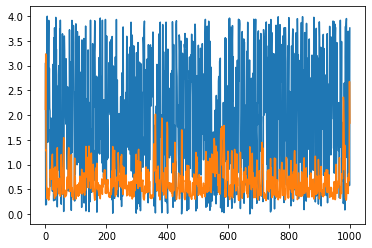

In [4]:
gs_data = GS_data_generator([2,BOXLENGTH], V_gen=V_GEN)
ev, u, V = gs_data.data_gen()
print("Ground state eigenvalue is:", ev[0])
pylab.plot(V[0])
pylab.plot(u[0])
pylab.show()

In [5]:
# int, int, method --> tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor
# generates:
# data_size x boxlength shaped shaped ground state eigenvalues
# data_size x boxlength x 1 shaped shaped u
# data_size x boxlength x 1 shaped shaped V
def _gen_data(data_size=DATA_SIZE, boxlength = BOXLENGTH, V_gen=None):
    data_generator = GS_data_generator([data_size, boxlength], V_gen=V_gen)
    ev, u, V = data_generator.data_gen()
    ev = tf.convert_to_tensor(ev, dtype=np.float32)
    u = tf.convert_to_tensor(u, dtype=np.float32)[..., tf.newaxis]
    V = tf.convert_to_tensor(V, dtype=np.float32)[..., tf.newaxis]
    return ev, u, V, tf.concat([u,V], axis=2)

# output is a pair, each of the format: ev, u, V, uV   
def gen_data(data_size=DATA_SIZE, boxlength = BOXLENGTH, batch_size=BATCH_SIZE, V_gen=None):
    train_ = _gen_data(data_size=data_size*10, V_gen=V_gen)
    test_ = _gen_data(data_size=data_size, V_gen=V_gen)
    
    train_ds, test_ds = [], []
    for i in range(3):
        train_ds.append(tf.data.Dataset.from_tensor_slices((train_[i+1], train_[0])).shuffle(10*data_size).batch(batch_size))
        test_ds.append(tf.data.Dataset.from_tensor_slices((test_[i+1], test_[0])).batch(batch_size))
    
    return train_ds, test_ds

In [6]:
#train_ds, test_ds = gen_data(V_gen=V_GEN)
#train_ds

## 5. CNN+fc model

In [7]:
class GSNN(Model):
    def __init__(self, boxlength=BOXLENGTH, kernel_size=KERNEL_SIZE, strides=STRIDES, input_channel=1, model_name=''):
        super(GSNN, self).__init__(name='')
        self.model_name = model_name
        
        # input B x 1000 x input_channel -> output B x 100 x 25
        self.conv1a = layers.Conv1D(25, kernel_size, strides=strides, input_shape=(None, boxlength, input_channel))
        self.bn1a = layers.BatchNormalization()

        # input B x 100 x 25 -> output B x 10 x 50 
        self.conv1b = layers.Conv1D(50, kernel_size, strides=strides)
        self.bn1b = layers.BatchNormalization()

        # input B x 10 x 50  -> output B x 1 x 75
        self.conv1c = layers.Conv1D(75, kernel_size, strides=strides)
        self.bn1c = layers.BatchNormalization()

        self.fc1 = layers.Dense(50, activation='tanh')
        self.fc2 = layers.Dense(25, activation='tanh')
        self.fc3 = layers.Dense(1, activation='softplus')
    
    def call(self, x, training=False):
        # x has size Batch x BOXLENGTH x channel (==1)
        
        # input B x 1000 x 2 -> output B x 100 x 25
        x = self.conv1a(x)
        x = self.bn1a(x)
        x = tf.nn.relu(x)

        # input B x 100 x 25 -> output B x 10 x 50 
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = tf.nn.relu(x)

        # input B x 10 x 50  -> output B x 1 x 75
        x = self.conv1c(x)
        x = self.bn1c(x)
        x = tf.nn.relu(x)

        # input B x 1 x 75 x 1 -> B x 75
        x = tf.squeeze(x)
        #print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x
        

### Example 1 forward pass

In [8]:
gsnn0 = GSNN(input_channel=2)
x = tf.concat([u[..., np.newaxis], V[..., np.newaxis]], axis=2)
gsnn0.call(x)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: id=339, shape=(2, 1), dtype=float32, numpy=
array([[0.6567018],
       [0.6186776]], dtype=float32)>

## Training

In [9]:
def train(model, train_ds=None, test_ds=None, epochs=EPOCHS):
    loss_object = tf.keras.losses.MeanAbsolutePercentageError()
    optimizer = tf.keras.optimizers.Adam()
    
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    test_loss = tf.keras.metrics.Mean(name='test_loss')
    
    @tf.function
    def train_step(x, target):
        with tf.GradientTape() as tape:
            predictions = model(x)
            loss = loss_object(target, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            train_loss(loss)
            
            
    @tf.function
    def test_step(x, target):
        predictions = model(x)
        t_loss = loss_object(target, predictions)

        test_loss(t_loss)
    
    

    for epoch in range(epochs):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        test_loss.reset_states()

        for train_V, train_ev in train_ds:
            train_step(train_V, train_ev)

        for test_V, test_ev in test_ds:
            test_step(test_V, test_ev)

        template = 'Epoch {}, Loss: {}, Test Loss: {}'
        print(template.format(epoch+1,
                            train_loss.result(),
                            test_loss.result()))

In [10]:
def compare_models(V_gen=V_GEN, epochs=EPOCHS):
    # generating data sets
    train_ds, test_ds = gen_data(V_gen=V_gen)
    
    # defining models
    models = []
    models.append(GSNN(input_channel=1, model_name='u based'))
    models.append(GSNN(input_channel=1, model_name='V based'))
    models.append(GSNN(input_channel=2, model_name='uV based'))
    
    # training
    for i, model in enumerate(models):
        print("-------------------------------------------")
        print("| Starting training for {} model".format(model.model_name))
        print("-------------------------------------------")
        
        train(model, train_ds=train_ds[i], test_ds=test_ds[i], epochs=epochs)
        print("")
    print("Training finished\n")
    
    # displaying some numerical values
    sample = _gen_data(10, V_gen=V_gen)
    print("-------------------------------------------")
    print("| Displaying numerical values for comparison")
    print("-------------------------------------------")
    print("True eigenvalues:")
    print(sample[0])
    
    
    pred = []
    for i in range(3):
        pred.append(models[i].call(sample[i+1]))
        print("")
        print("Results from {} GSNN".format(models[i].model_name))
        print(pred[i])
    

In [11]:
compare_models()

-------------------------------------------
| Starting training for u based model
-------------------------------------------
Epoch 1, Loss: 11.910367965698242, Test Loss: 10.883275032043457
Epoch 2, Loss: 9.545738220214844, Test Loss: 8.697593688964844
Epoch 3, Loss: 6.82357931137085, Test Loss: 6.351386070251465
Epoch 4, Loss: 5.151533126831055, Test Loss: 4.669795036315918
Epoch 5, Loss: 4.050140857696533, Test Loss: 4.949039936065674
Epoch 6, Loss: 3.449467658996582, Test Loss: 3.629777431488037
Epoch 7, Loss: 3.0514907836914062, Test Loss: 3.3717989921569824
Epoch 8, Loss: 2.812426805496216, Test Loss: 3.2125606536865234
Epoch 9, Loss: 2.5582733154296875, Test Loss: 3.3460583686828613
Epoch 10, Loss: 2.4605255126953125, Test Loss: 3.08304500579834
Epoch 11, Loss: 2.3236794471740723, Test Loss: 2.878068447113037
Epoch 12, Loss: 2.182044267654419, Test Loss: 3.455571413040161
Epoch 13, Loss: 2.173272132873535, Test Loss: 2.6943509578704834
Epoch 14, Loss: 2.0707409381866455, Test Lo